<a href="https://colab.research.google.com/github/sharonma1218/stats-306/blob/main/lecture08_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# earnings differences, men vs women
load(url('https://datasets.stats306.org/cps.RData'))

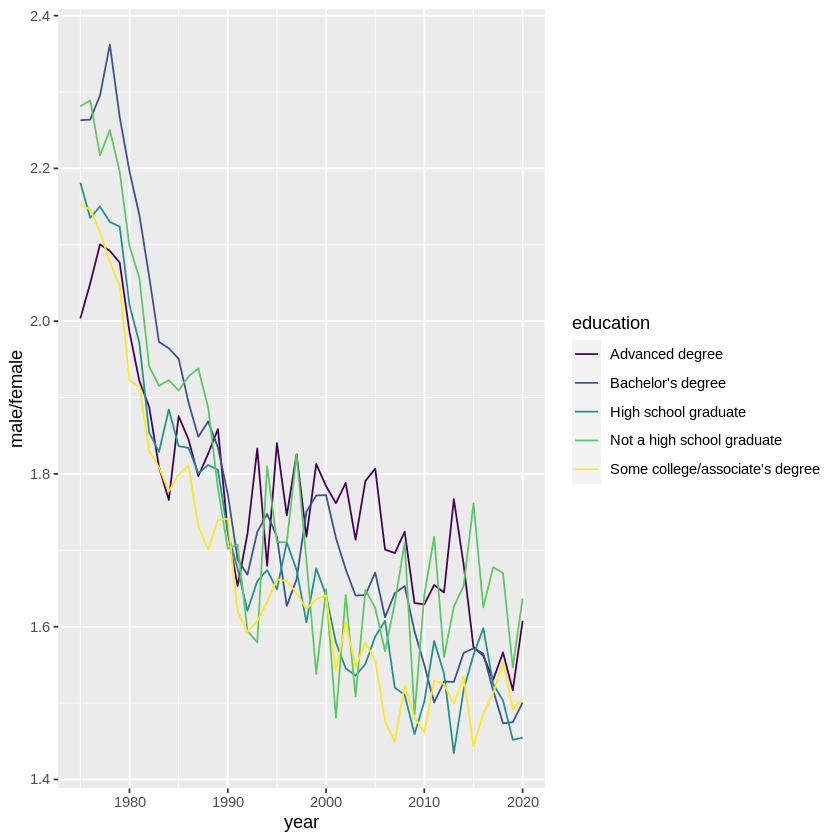

In [3]:
# make better plot
earnings %>% select(education, year, sex, Mean) %>% pivot_wider(names_from=sex, values_from=Mean) %>% 
    ggplot(aes(x = year, y = male / female, color = education)) + geom_line()

To explore this relationship further, we naturally want to bring in other data. For example, one hypothesis is that the wage gap is diminshing in part because women are having fewer children. To study this, we want to get some data about childbearing tendencies in the U.S., and see study how it relates to the wage gap.

The U.S. census has [detailed data](https://www.census.gov/data/tables/time-series/demo/fertility/his-cps.html#par_list) on female childbearing over time.

I have gone ahead and extracted these a subset of this spreadsheet into the following data frame:

In [4]:
pct_childless <- tibble::tribble(
  ~year, ~X25.29, ~X35.39,
   2018,    54.2,    33.6,
   2016,    53.8,    30.8,
   2014,    49.6,    28.9,
   2012,    49.4,    28.2,
   2010,    47.6,    29.7,
   2008,    46.2,    26.8,
   2006,    45.6,    26.2,
   2004,    44.2,    27.6,
   2002,    45.5,    27.7,
   2000,    44.2,    28.1,
   1998,    43.5,    27.4,
   1995,    43.8,    26.7,
   1994,    43.6,    26.3,
   1992,    41.3,    26.1,
   1990,    42.1,    25.7,
   1988,    42.2,    25.1,
   1987,    39.3,    23.6,
   1986,    40.7,    23.9,
   1985,    41.5,    26.2,
   1984,    39.9,    23.5,
   1983,    39.5,    22.9,
   1982,    38.8,    22.5,
   1981,    37.2,    20.6,
   1980,    36.8,    19.8,
   1976,    30.8,    15.6
  )

(Next week you will learn how to import data from spreadsheets on your own.)

In [5]:
print(pct_childless)

# A tibble: 25 × 3
    year X25.29 X35.39
   <dbl>  <dbl>  <dbl>
 1  2018   54.2   33.6
 2  2016   53.8   30.8
 3  2014   49.6   28.9
 4  2012   49.4   28.2
 5  2010   47.6   29.7
 6  2008   46.2   26.8
 7  2006   45.6   26.2
 8  2004   44.2   27.6
 9  2002   45.5   27.7
10  2000   44.2   28.1
# … with 15 more rows


To compare these data, we need to somehow "match up" the data in `earnings` and `pct_childless`. An "ideal" table for studying this relationship would look like:

```
    # A tibble: 25 × 3
        year   age     wage.gap   pct.childless
       <dbl>  <fct>   <dbl>      <dbl>
     1  2018   25-29   1.451      .14
     2  2018   35-39   1.143      .10
    # … with 23 more rows
```

This lecture will teach us about "joining" data in this way.

# Lecture 09: Relational Data
<div style="border: 1px double black; padding: 10px; margin: 10px">

**Goals for today's lecture:**
* Learn about [keys](#Keys)
* Different types of [relations](#Relations) between tables
* [Commands for joining related tables together](#Outer-joins)
</div>


We have already spent a lot of time analyzing the `flights` table. In fact, there are four other tables in `nycflights13` that contain related information about these flights:

In [9]:
install.packages('nycflights13')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
library(nycflights13)

In [11]:
print(airlines)

# A tibble: 16 × 2
   carrier name                       
   <chr>   <chr>                      
 1 9E      Endeavor Air Inc.          
 2 AA      American Airlines Inc.     
 3 AS      Alaska Airlines Inc.       
 4 B6      JetBlue Airways            
 5 DL      Delta Air Lines Inc.       
 6 EV      ExpressJet Airlines Inc.   
 7 F9      Frontier Airlines Inc.     
 8 FL      AirTran Airways Corporation
 9 HA      Hawaiian Airlines Inc.     
10 MQ      Envoy Air                  
11 OO      SkyWest Airlines Inc.      
12 UA      United Air Lines Inc.      
13 US      US Airways Inc.            
14 VX      Virgin America             
15 WN      Southwest Airlines Co.     
16 YV      Mesa Airlines Inc.         


In [12]:
airports %>% 
  filter(faa == "DTW")

faa,name,lat,lon,alt,tz,dst,tzone
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
DTW,Detroit Metro Wayne Co,42.21244,-83.35339,645,-5,A,America/New_York


In [13]:
print(planes)

# A tibble: 3,322 × 9
   tailnum  year type                   manuf…¹ model engines seats speed engine
   <chr>   <int> <chr>                  <chr>   <chr>   <int> <int> <int> <chr> 
 1 N10156   2004 Fixed wing multi engi… EMBRAER EMB-…       2    55    NA Turbo…
 2 N102UW   1998 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 3 N103US   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 4 N104UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 5 N10575   2002 Fixed wing multi engi… EMBRAER EMB-…       2    55    NA Turbo…
 6 N105UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 7 N107US   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 8 N108UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 9 N109UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
10 N110UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
# … wi

In [14]:
print(weather)

# A tibble: 26,115 × 15
   origin  year month   day  hour  temp  dewp humid wind_dir wind_speed wind_g…¹
   <chr>  <int> <int> <int> <int> <dbl> <dbl> <dbl>    <dbl>      <dbl>    <dbl>
 1 EWR     2013     1     1     1  39.0  26.1  59.4      270      10.4        NA
 2 EWR     2013     1     1     2  39.0  27.0  61.6      250       8.06       NA
 3 EWR     2013     1     1     3  39.0  28.0  64.4      240      11.5        NA
 4 EWR     2013     1     1     4  39.9  28.0  62.2      250      12.7        NA
 5 EWR     2013     1     1     5  39.0  28.0  64.4      260      12.7        NA
 6 EWR     2013     1     1     6  37.9  28.0  67.2      240      11.5        NA
 7 EWR     2013     1     1     7  39.0  28.0  64.4      240      15.0        NA
 8 EWR     2013     1     1     8  39.9  28.0  62.2      250      10.4        NA
 9 EWR     2013     1     1     9  39.9  28.0  62.2      260      15.0        NA
10 EWR     2013     1     1    10  41    28.0  59.6      260      13.8        NA
# … 

Together these four tables form a *relational database*. The relationships can be graphed like so:
![table relationships](http://r4ds.had.co.nz/diagrams/relational-nycflights.png)

The particular relationships in this database are:
- `flights` connects to `planes` via `tailnum`.
- `flights` connects to `airlines` via `carrier`.
- `flights` connects to `airports` twice: via `origin` and `dest`.
- `flights` connects to `weather` via `origin` (the location), and `year`, `month`, `day` and `hour`.

## Keys
The "key" to understanding relational databases is... keys. 



### Primary Key
A *primary key* is a variable (or set of variables) that uniquely identifies an observation in its own table: there is **at most** one row in the table that corresponds to any setting of the columns which comprise the key.

In [ ]:
# key = one of the columns/variables 
# can also be a group of columns 

In the `planes` table, each airplane is identified by its `tailnum`:

In [ ]:
print(planes)

# A tibble: 3,322 x 9
   tailnum  year type          manufacturer   model  engines seats speed engine 
   <chr>   <int> <chr>         <chr>          <chr>    <int> <int> <int> <chr>  
 1 N10156   2004 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 2 N102UW   1998 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 3 N103US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 4 N104UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 5 N10575   2002 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 6 N105UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 7 N107US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 8 N108UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 9 N109UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
10 N110UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
# … wi

The tail number of an airplane is assigned by a government agency and is unique: no two planes can have the same tail number. Thus, `tailnum` should be a primary key in this table. 

To check that one or more variables constitutes a primary key, we can group by those variables and then check that the number of distinct values equals the number of rows in the data set:

In [ ]:
# planes %>% print
planes %>% 
  summarize(n = n(), 
  nd = n_distinct(tailnum)) 
# n counts everything/total num of rows
# distinct() gives you the dataframe w distinct values
# n_distinct() gives the the number of distinct values 

  n    nd  
1 3322 3322

Compare with `flights`, where tailnum does *not* uniquely identify each row. (There are many flights present for the same airplane.)

In [15]:
distinct(flights, tailnum) %>% print

# A tibble: 4,044 × 1
   tailnum
   <chr>  
 1 N14228 
 2 N24211 
 3 N619AA 
 4 N804JB 
 5 N668DN 
 6 N39463 
 7 N516JB 
 8 N829AS 
 9 N593JB 
10 N3ALAA 
# … with 4,034 more rows


In [16]:
count(flights,tailnum) %>% print
# found 4 records/rows for tailnum=D942DN
# counts the number of records/rows for each tailnum in the flights dataset

# A tibble: 4,044 × 2
   tailnum     n
   <chr>   <int>
 1 D942DN      4
 2 N0EGMQ    371
 3 N10156    153
 4 N102UW     48
 5 N103US     46
 6 N104UW     47
 7 N10575    289
 8 N105UW     45
 9 N107US     41
10 N108UW     60
# … with 4,034 more rows


What is the primary key for the `flights` table?

In [19]:
# step 1
flights %>% 
  filter(is.na(tailnum)) %>% # tailnum is NA; can't identify the plane 
  count(year, month, day, dep_time, tailnum) %>%
  print

# A tibble: 316 × 6
    year month   day dep_time tailnum     n
   <int> <int> <int>    <int> <chr>   <int>
 1  2013     1     2       NA NA          2
 2  2013     1     3       NA NA          2
 3  2013     1     4       NA NA          2
 4  2013     1     5       NA NA          1
 5  2013     1     7       NA NA          1
 6  2013     1     8       NA NA          1
 7  2013     1     9       NA NA          2
 8  2013     1    10       NA NA          2
 9  2013     1    11       NA NA          1
10  2013     1    12       NA NA          2
# … with 306 more rows


In [21]:
# step 2 
flights %>% 
  filter(!is.na(tailnum)) %>% # tailnum is NOT NA
  count(year, month, day, dep_time, tailnum) %>%
  print

# A tibble: 333,751 × 6
    year month   day dep_time tailnum     n
   <int> <int> <int>    <int> <chr>   <int>
 1  2013     1     1      517 N14228      1
 2  2013     1     1      533 N24211      1
 3  2013     1     1      542 N619AA      1
 4  2013     1     1      544 N804JB      1
 5  2013     1     1      554 N39463      1
 6  2013     1     1      554 N668DN      1
 7  2013     1     1      555 N516JB      1
 8  2013     1     1      557 N593JB      1
 9  2013     1     1      557 N829AS      1
10  2013     1     1      558 N29129      1
# … with 333,741 more rows


In [24]:
# step 3 
flights %>% 
  filter(!is.na(tailnum)) %>%
  count(year, month, day, dep_time, tailnum) %>%
  filter(n>1 & !is.na(dep_time)) %>% # added filter 
  print
# makes sense b/c flight can only be at one place at a time 

# A tibble: 0 × 6
# … with 6 variables: year <int>, month <int>, day <int>, dep_time <int>,
#   tailnum <chr>, n <int>


We might guess that `year`, `month`, `day`, and `tailnum` are sufficient to identify each row in `flights`, but this is not true:

In [25]:
flights %>% 
  summarize(n=n(), # total num of records/rows
  nd=n_distinct(year, month, day, tailnum)) # total number of distinct records/rows 

n,nd
<int>,<int>
336776,251727


In fact, even restricting to the exact *minute* that an airplane departed is not sufficient:

In [27]:
flights %>% 
  summarize(n=n(), 
  nd=n_distinct(tailnum, time_hour, minute))

n,nd
<int>,<int>
336776,336367


This says that there are certain airplanes that are marked as having departed more than once in the same year, month, day, hour and minute. We can inspect these rows as follows:

In [28]:
group_by(flights, tailnum, time_hour, minute) %>% 
  count %>% 
    filter(n>1) %>% 
      arrange(tailnum, time_hour) %>% 
        print
# on june 10, this particular flight magically went to two places at the same time

# A tibble: 298 × 4
# Groups:   tailnum, time_hour, minute [298]
   tailnum time_hour           minute     n
   <chr>   <dttm>               <dbl> <int>
 1 N11119  2013-06-10 16:00:00     55     2
 2 N11192  2013-08-26 08:00:00     30     2
 3 N12563  2013-02-04 16:00:00     19     2
 4 N12564  2013-01-13 20:00:00      0     2
 5 N12900  2013-07-10 21:00:00     29     2
 6 N13969  2013-01-28 07:00:00     59     2
 7 N14148  2013-03-12 06:00:00     30     2
 8 N14558  2013-04-19 13:00:00     29     2
 9 N14916  2013-02-11 13:00:00     15     2
10 N14974  2013-07-26 06:00:00     30     2
# … with 288 more rows


These likely indicate data entry errors.

## 🤔 Quiz

What column(s) constitute a primary key in the `planes` table?

<ol style="list-style-type: upper-alpha;">
    <li><code>tailnum</code> only</li>
    <li><code>tailnum</code> and <code>model</code></li>
    <li><code>model</code> only</li>
    <li><code>model</code> and <code>engines</code></li>
    <li><code>model</code>, <code>engines</code>, and <code>year</code></li>
</ol>



In [ ]:
# primary key for planes

## 🤔 Quiz

What column(s) constitute a primary key in the `mpg` table?

<ol style="list-style-type: upper-alpha;">
    <li><code>manufacturer</code> and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, <code>displ</code>, and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, <code>displ</code>, <code>trans</code>, and <code>model</code></li>
    <li>None of these</li>
</ol>



In [35]:
# primary key in mpg 
# use count() on a group of variables & see if n=1 

count(mpg,manufacturer,year,displ,trans,model)%>%
  arrange(desc(n))%>%
  print

count(mpg,manufacturer,year,displ,trans,model)%>%
  filter(n>1)%>%
  print

# you should never conclude whether or not a combo is truly a primary key from just the first few rows. make sure to filter for n>1 


# A tibble: 207 × 6
   manufacturer  year displ trans      model                   n
   <chr>        <int> <dbl> <chr>      <chr>               <int>
 1 chevrolet     2008   5.3 auto(l4)   c1500 suburban 2wd      3
 2 dodge         2008   3.3 auto(l4)   caravan 2wd             3
 3 dodge         2008   4.7 auto(l5)   dakota pickup 4wd       3
 4 dodge         2008   4.7 auto(l5)   durango 4wd             3
 5 dodge         2008   4.7 auto(l5)   ram 1500 pickup 4wd     3
 6 dodge         2008   4.7 manual(m6) ram 1500 pickup 4wd     3
 7 honda         1999   1.6 manual(m5) civic                   3
 8 chevrolet     2008   5.3 auto(l4)   k1500 tahoe 4wd         2
 9 dodge         1999   3.3 auto(l4)   caravan 2wd             2
10 dodge         1999   3.8 auto(l4)   caravan 2wd             2
# … with 197 more rows
# A tibble: 20 × 6
   manufacturer  year displ trans      model                   n
   <chr>        <int> <dbl> <chr>      <chr>               <int>
 1 chevrolet     2008   5.3 

## Relations
A primary key and the corresponding foreign key in another table form a *relation*. Relations come in several forms:
- *One-to-many*. (Most common). For example, each flight has one plane, but each plane has many flights. 
- *Many-to-many*: For example, each airline flies to many airports; each airport hosts many airlines.
- *One-to-one*. Each row in one table corresponds uniquely to a row in a second table. This is relatively uncommon because you could just as easily combine the two tables into one.

In [36]:
x = tribble(
  ~key, ~val_x,
     1, "x1",
     2, "x2",
     3, "x3"
)
y = tribble(
  ~key, ~val_y,
     1, "y1",
     2, "y2",
     4, "y3"
)

In [37]:
x
y
# the columns in these tibbles can each be primary keys

key,val_x
<dbl>,<chr>
1,x1
2,x2
3,x3


key,val_y
<dbl>,<chr>
1,y1
2,y2
4,y3


## Joins
Joins are the way the we combine or "merge" two data tables based on keys.
To understand how joins work we'll study these two simple tables:
![simple tables](http://r4ds.had.co.nz/diagrams/join-setup.png)

In [ ]:
# it's mostly w/ the keys that you can use to join the tables (the one unique identifier)

### Inner joins
Inner joins match a pair of observations whenever their keys are equal:
![match example](https://r4ds.hadley.nz/diagrams/join/inner.png)

In [ ]:
# x3 and y3 are dropped b/c even if only one key is diff, both rows get dropped 

In [38]:
x %>% inner_join(y, by = "key")
# join by the col "key"

key,val_x,val_y
<dbl>,<chr>,<chr>
1,x1,y1
2,x2,y2


In [39]:
x %>% inner_join(y)
# even w/o specifying, R automatically figured it out for us 

Joining, by = "key"


key,val_x,val_y
<dbl>,<chr>,<chr>
1,x1,y1
2,x2,y2


Note that there is no row for `key=3` or `key=4`: with an inner join, unmatched rows are not included in the result. For this reason, we do not as often use inner joins for data analysis since you can easily lose observations.

### Outer joins
An outer join keeps observations that appear in at least one of the tables. There are three types of outer joins:
- A left join keeps all observations in x.
- A right join keeps all observations in y.
- A full join keeps all observations in x and y.

![match example](https://r4ds.hadley.nz/diagrams/join/left.png)

![match example](https://r4ds.hadley.nz/diagrams/join/right.png)

![match example](https://r4ds.hadley.nz/diagrams/join/full.png)

Left joins are the most common. Use them to look up data in another table, but preserve your original observations when there in cases where the other table does not have a match.

In [ ]:
# left join: you don't want to drop ANYTHING from the left table! 

### Example
The `flights` table has a `carrier` column which is a two-letter code for the airline. The `airlines` table maps these code to recognizable airline names. 

How many flights are there per carrier in the dataset?

In [40]:
# flights per carrier
flights%>%
  count(carrier)%>%
  print

# A tibble: 16 × 2
   carrier     n
   <chr>   <int>
 1 9E      18460
 2 AA      32729
 3 AS        714
 4 B6      54635
 5 DL      48110
 6 EV      54173
 7 F9        685
 8 FL       3260
 9 HA        342
10 MQ      26397
11 OO         32
12 UA      58665
13 US      20536
14 VX       5162
15 WN      12275
16 YV        601


In [41]:
flights%>%
  count(carrier)%>%
  left_join(airlines)%>% # bc we want to know the names of the carriers as well
  print

Joining, by = "carrier"


# A tibble: 16 × 3
   carrier     n name                       
   <chr>   <int> <chr>                      
 1 9E      18460 Endeavor Air Inc.          
 2 AA      32729 American Airlines Inc.     
 3 AS        714 Alaska Airlines Inc.       
 4 B6      54635 JetBlue Airways            
 5 DL      48110 Delta Air Lines Inc.       
 6 EV      54173 ExpressJet Airlines Inc.   
 7 F9        685 Frontier Airlines Inc.     
 8 FL       3260 AirTran Airways Corporation
 9 HA        342 Hawaiian Airlines Inc.     
10 MQ      26397 Envoy Air                  
11 OO         32 SkyWest Airlines Inc.      
12 UA      58665 United Air Lines Inc.      
13 US      20536 US Airways Inc.            
14 VX       5162 Virgin America             
15 WN      12275 Southwest Airlines Co.     
16 YV        601 Mesa Airlines Inc.         


## 🤔 Quiz

How many flights departing from EWR were operated by Envoy Air?

<ol style="list-style-type: upper-alpha;">
    <li>46087</li>
    <li>26397</li>
    <li>2276</li>
    <li>18460</li>
    <li>43939</li>
</ol>

In [42]:
# envoy flights from ewr
# method 1 
flights%>%
  count(origin=="EWR" & carrier=="MQ")%>%
  print

# A tibble: 2 × 2
  `origin == "EWR" & carrier == "MQ"`      n
  <lgl>                                <int>
1 FALSE                               334500
2 TRUE                                  2276


In [43]:
# method 2 
flights%>%
  filter(origin=="EWR")%>%
  left_join(airlines)%>%
  filter(name=="Envoy Air")%>%
  count

Joining, by = "carrier"


n
<int>
2276


In [45]:
# method 3 
flights%>%
  left_join(airlines)%>% # so u can easily access the name of the airline 
  filter(origin=="EWR" & name=="Envoy Air")%>%
  count

Joining, by = "carrier"


n
<int>
2276


### Duplicate keys
Although we have defined keys in terms of uniqueness, it's not required that a key be unique. There are several possibilities:

##### One table has duplicate keys
This is useful when you want to add in additional information as there is typically a one-to-many relationship.
![duplicate keys](http://r4ds.had.co.nz/diagrams/join-one-to-many.png)

In fact, we already saw an example of this above when we joined `planes` to `flights`: each plane belongs to potentially many flights.

### Exercise
What is the most common model of airplane used by each carrier?

In [47]:
planes%>%print # the model variable is hidden here in the planes table, not the flights table 

# A tibble: 3,322 × 9
   tailnum  year type                   manuf…¹ model engines seats speed engine
   <chr>   <int> <chr>                  <chr>   <chr>   <int> <int> <int> <chr> 
 1 N10156   2004 Fixed wing multi engi… EMBRAER EMB-…       2    55    NA Turbo…
 2 N102UW   1998 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 3 N103US   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 4 N104UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 5 N10575   2002 Fixed wing multi engi… EMBRAER EMB-…       2    55    NA Turbo…
 6 N105UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 7 N107US   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 8 N108UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
 9 N109UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
10 N110UW   1999 Fixed wing multi engi… AIRBUS… A320…       2   182    NA Turbo…
# … wi

In [54]:
# most common model
flights%>%
  left_join(planes,by="tailnum")%>% # R might have prob finding the common col, so specify the col for them (tailnum). remember the "year" col in flights dataset is diff from the "year" col in the planes dataset! 
  group_by(carrier, model)%>%
  summarize(n=n())%>%
  top_n(1)%>% # for each carrier, this is the model that is used the most num of times 
  print

`summarise()` has grouped output by 'carrier'. You can override using the
`.groups` argument.
Selecting by n


# A tibble: 16 × 3
# Groups:   carrier [16]
   carrier model           n
   <chr>   <chr>       <int>
 1 9E      CL-600-2D24 10580
 2 AA      NA          22558
 3 AS      737-890       346
 4 B6      A320-232    34063
 5 DL      MD-88       10191
 6 EV      EMB-145LR   28027
 7 F9      A320-214      617
 8 FL      717-200      2774
 9 HA      A330-243      342
10 MQ      NA          25397
11 OO      CL-600-2C10    25
12 UA      737-824     13809
13 US      A319-112     5844
14 VX      A320-214     4859
15 WN      737-7H4     10389
16 YV      CL-600-2C10   311


##### Both tables have duplicate keys
This represents a many-to-many join and is usually an error since they key does not uniquely identify observations in either table. Joining duplicated keys results in the Cartesian product of all the possible matches:
![cartesian](https://r4ds.hadley.nz/diagrams/join/full.png)

Be careful when doing many-to-many merges. It's possible to generate huge tables by accident and crash R.

## 🤔 Quiz
To understand what the weather conditions were when each flight departed, I will join the weather table to the first 100 rows of the flights table using the command

```
flights %>% slice(1:100) %>% left_join(weather, by=c("origin", "hour"))
```

How many rows does the resulting table have?

<ol style="list-style-type: upper-alpha;">
    <li>100</li>
    <li>36344</li>
    <li>336776</li>
    <li>Zero</li>
    <li><code>NA</code></li>
</ol>

In [61]:
# there are 100 rows in the weather dataset, due to the slice, so there should be 100 rows in the resulting dataset 

# A tibble: 26,115 × 15
   origin  year month   day  hour  temp  dewp humid wind_dir wind_speed wind_g…¹
   <chr>  <int> <int> <int> <int> <dbl> <dbl> <dbl>    <dbl>      <dbl>    <dbl>
 1 EWR     2013     1     1     1  39.0  26.1  59.4      270      10.4        NA
 2 EWR     2013     1     1     2  39.0  27.0  61.6      250       8.06       NA
 3 EWR     2013     1     1     3  39.0  28.0  64.4      240      11.5        NA
 4 EWR     2013     1     1     4  39.9  28.0  62.2      250      12.7        NA
 5 EWR     2013     1     1     5  39.0  28.0  64.4      260      12.7        NA
 6 EWR     2013     1     1     6  37.9  28.0  67.2      240      11.5        NA
 7 EWR     2013     1     1     7  39.0  28.0  64.4      240      15.0        NA
 8 EWR     2013     1     1     8  39.9  28.0  62.2      250      10.4        NA
 9 EWR     2013     1     1     9  39.9  28.0  62.2      260      15.0        NA
10 EWR     2013     1     1    10  41    28.0  59.6      260      13.8        NA
# … 

In [58]:
# step 1 
flights %>% 
  slice(1:100) %>% 
    left_join(weather, by=c("origin", "hour")) %>% # not a good join b/c n!=100. we have 4 o'clock on jan 2, feb 3... we're joining all 4 o'clocks. bad.
      count

n
<int>
36344


In [60]:
# step 2 
flights %>% 
  slice(1:100) %>% 
    left_join(weather, by=c("origin", "year", "month", "day", "hour")) %>%
      count

n
<int>
100


### Defining the key columns
When we do a join using `left_join()`, R take as the key whatever column names the two tables have in common:

In [62]:
left_join(flights, planes) %>% print
   # select(year, month, day, origin, type, tailnum, manufacturer) %>% 
   # print

Joining, by = c("year", "tailnum")


# A tibble: 336,776 × 26
    year month   day dep_time sched_de…¹ dep_d…² arr_t…³ sched…⁴ arr_d…⁵ carrier
   <int> <int> <int>    <int>      <int>   <dbl>   <int>   <int>   <dbl> <chr>  
 1  2013     1     1      517        515       2     830     819      11 UA     
 2  2013     1     1      533        529       4     850     830      20 UA     
 3  2013     1     1      542        540       2     923     850      33 AA     
 4  2013     1     1      544        545      -1    1004    1022     -18 B6     
 5  2013     1     1      554        600      -6     812     837     -25 DL     
 6  2013     1     1      554        558      -4     740     728      12 UA     
 7  2013     1     1      555        600      -5     913     854      19 B6     
 8  2013     1     1      557        600      -3     709     723     -14 EV     
 9  2013     1     1      557        600      -3     838     846      -8 B6     
10  2013     1     1      558        600      -2     753     745       8 AA     
# …

In [65]:
left_join(flights,airports,by=c("origin"="faa"))%>%print

# A tibble: 336,776 × 26
    year month   day dep_time sched_de…¹ dep_d…² arr_t…³ sched…⁴ arr_d…⁵ carrier
   <int> <int> <int>    <int>      <int>   <dbl>   <int>   <int>   <dbl> <chr>  
 1  2013     1     1      517        515       2     830     819      11 UA     
 2  2013     1     1      533        529       4     850     830      20 UA     
 3  2013     1     1      542        540       2     923     850      33 AA     
 4  2013     1     1      544        545      -1    1004    1022     -18 B6     
 5  2013     1     1      554        600      -6     812     837     -25 DL     
 6  2013     1     1      554        558      -4     740     728      12 UA     
 7  2013     1     1      555        600      -5     913     854      19 B6     
 8  2013     1     1      557        600      -3     709     723     -14 EV     
 9  2013     1     1      557        600      -3     838     846      -8 B6     
10  2013     1     1      558        600      -2     753     745       8 AA     
# …

This is called a *natural join*. If the key column(s) are named differently in the two tables, we must specify the mapping between the two using the `by=` parameter.

Consider joining `airports` to `flights`:
```
> left_join(flights, airports)
Error: `by` required, because the data sources have no common variables
Traceback:

1. left_join(flights, airports)
2. left_join.tbl_df(flights, airports)
3. common_by(by, x, y)
4. common_by.NULL(by, x, y)
5. bad_args("by", "required, because the data sources have no common variables")
6. glubort(fmt_args(args), ..., .envir = .envir)
7. .abort(text)
```

This has produced an error, because airports and flights do not have any columns in common. Indeed, the three digit FAA code is called `faa` in `airports`, but appears as either `origin` or `dest` in `flights`. To fix the error, we must specify which of `origin` or `dest` should be matched:

In [ ]:
# join_by

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/World_map_indicating_tropics_and_subtropics.png/640px-World_map_indicating_tropics_and_subtropics.png" style="float: right; margin:0 0 0 20px;" />

## 🤔 Quiz

How many flights in February were bound for tropical destinations?

<ol style="list-style-type: upper-alpha;">
    <li>56</li>
    <li>18</li>
    <li>71</li>
    <li>39</li>
    <li>50</li>
</ol>

(Note: there is a technical definition of what it means to be located in the tropics. It does not have to do with sitting on the beach.)

In [71]:
# tropical flights
flights%>%
  left_join(airports,by=c("dest"="faa"))%>%
  filter(month==2 & lat<=23.5)%>%
  count

n
<int>
56


## Filtering joins

Filtering joins allow us to filter rows on one table based on their presence or absence in another table. We've already seen some examples of this on the problem sets:

In [72]:
dest_top6 <- count(flights, dest) %>% top_n(6)
filter(flights, dest %in% dest_top6$dest) %>% nrow

Selecting by n


[1] 94326

### Semi-join
`semi_join(x, y)` keeps all the observations in `x` that are also in `y`.
![semi join](http://r4ds.had.co.nz/diagrams/join-semi.png)

In [75]:
# find all the flight with destinations in the top 6
flights%>%
  right_join(dest_top6%>%top_n(6))%>%
  count

Selecting by n
Joining, by = "dest"


n
<int>
94326


## 🤔 Quiz
The top ten most popular days to fly were:

```count(flights, year, month, day) %>% top_n(10)```

What is the overall fraction of flights that left on these ten days?

<ol style="list-style-type: upper-alpha;">
    <li>0.024</li>
    <li>0.042</li>
    <li>1.000</li>
    <li>0.001</li>
    <li>0.039</li>
</ol>

### Anti-join
`anti_join(x, y)` _drops_ all the observations in `x` that are also in `y`.
![anti join](http://r4ds.had.co.nz/diagrams/join-anti.png)

## Example
All the tail numbers that are missing in planes:

In [ ]:
# tail numbers in flights but not in planes

What do all these missing tail numbers have in common?

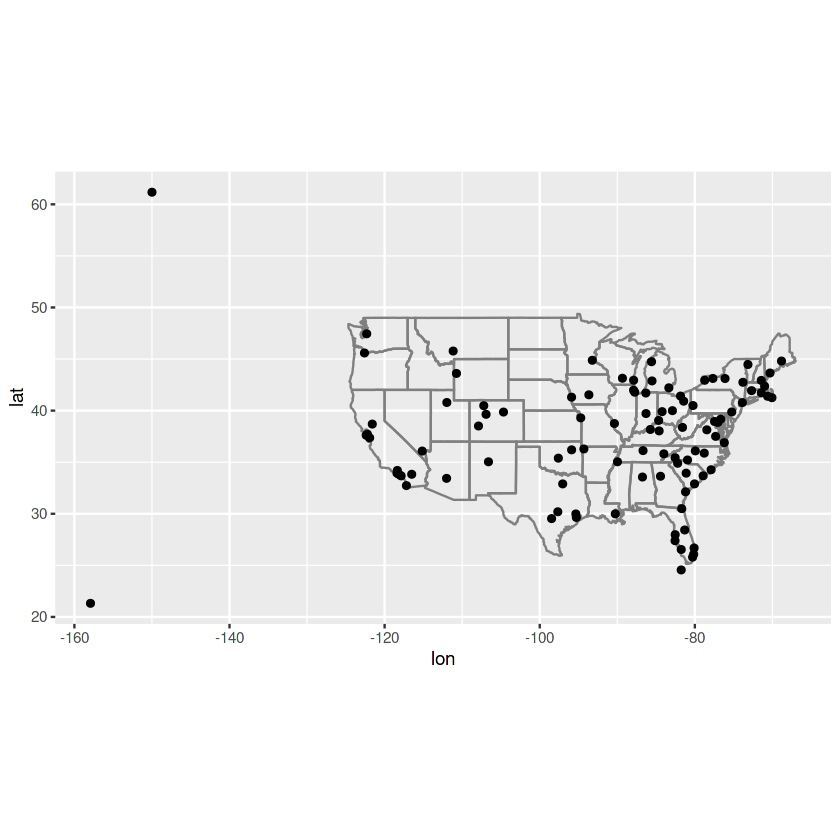

In [ ]:
airports |>
  semi_join(flights, join_by(faa == dest)) |>
  ggplot(aes(x = lon, y = lat)) +
    borders("state") +
    geom_point() +
    coord_quickmap()